In [4]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from datetime import datetime as dt
import unidecode
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
import string
# import cv2


import re
import pickle

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve, f1_score, plot_confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.colors import Normalize

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

from scipy.sparse import hstack
from scipy.special import logit, expit

# from my_nmf import NMF
# from helpers import build_text_vectorizer, hand_label_topics, analyze_article

plt.style.use('seaborn')
# os.chdir("data")

In [5]:
file = 'data/comments.csv'
df = pd.read_csv(file, names = ['Text', 'ID', 'Subreddit', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes', 'Author_link_karma', 'Author_Comment_Karma','Author_has_gold?'], parse_dates =True, encoding = 'utf-8')


In [6]:
df = df.dropna(axis =0)

# make meta dataframes

In [479]:
df_entertainment = df.dropna(axis =0).loc[df['meta']== 'entertainment']
# df_entertainment.Text
df

# Proper Pipeline, no alaska

In [9]:
def clean_urls(array):
    lst = []
    for string in array:
#         remove url strings
        if string > re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE):
            string = re.sub(r'(https|http)? : \/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
#           remove extra youtube v's
            string = re.sub(r'v = () ', '', string, flags = re.MULTILINE)
            lst.append(string)
        else: 
            string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string, flags=re.MULTILINE)
            lst.append(string)
    return lst
# test
# tokelems = clean_urls(df_entertainment.Text.values)
# cleaned_urls
# type(cleaned_urls[1])

In [11]:
punctuations = '''.!=-()[]{};:"|\<>/?@#$%^&*_~'''
replace = '{}'.format('\n')
lst = []

test_strings = ['James ran ForWard from the https://  !!! $ %   youtube.com v asfhabjf v asvjdakbfakdfasdfbasdfadfsasfadga %666^^ 32$']
# test_strings2 = df_entertainment.Text.values[:2]
# print(test_strings2)

def base_clean_up(strings):
    new_strings = [] 
    for i in strings:
#         lower the strings
        i = i.lower()
#         convert strings to unicode
        i = unidecode.unidecode(i)
#         remove extra spaces
        i = re.sub(" +", " ", i)
        no_punct = ""
        for word in i.split():
#             remove any individual letters or extra spaces
            word = re.sub(r'[^\w\s]','',word)
            
            if len(word) > 20:
                word = ""
            no_punct += f'{word} '
        new_strings.append(no_punct)
#         print(no_punct)
    return new_strings



# # test check
clean_test = base_clean_up(test_strings)
print(clean_test)
# check using df
# tokelems = base_clean_up(tokelems)  
# base_clean_up1
# clean_test

['james ran forward from the https    youtubecom v asfhabjf v  666 32 ']


In [24]:
s_stop = set(stopwords.words())
print(len(s_stop))
new_stops = ['would', 'get', 'why', 'what', 'where', 'politics', 'libertarian', 'worldnews', 'offbeat', 'news',
       'truereddit', 'conspiracy', 'conservative', 'frugal',
       'motorcycles', 'sex', 'drunk', 'food', 'lifehacks', 'guns',
       'progresspics', 'askscience', 'science', 'explainlikeimfive',
       'askhistorians', 'youshouldknow', 'todayilearned', 'space',
       'circlejerk', 'facepalm', 'jokes', 'adviceanimals', 'funny',
       'imgoingtohellforthis', 'movies', 'harrypotter', 'music', 'anime',
       'comicbooks', 'starwars', 'doctorwho', 'community', 'breakingbad',
       'thewalkingdead', 'startrek', 'mylittlepony', 'gameofthrones',
       'himym', 'tf2', 'dota2', 'leagueoflegends', 'minecraft', 'pokemon',
       'gaming', 'skyrim', 'starcraft','nt','like', 'really', '2015ref',
        'publisherspage190ref','volume9', 'issue2','005', '1671', '2015', 
        'jpgthumbemerg', 'jpgthumbrightth', 'logo', 'page7','logo.png','2015.ref', 
        'nameleaf200kcit','ref', '005.jpgthumbrightth', 'whose', 'kind','png', 'jpg', 
        'wiktionaryzero', 'wiktionaryzero0', 'wiktionaryzero0', 'articlesquantum','0supsup', 
        '0refcit', '1-3', 'redirectzero', '.', ',', 'nameleaf200k2cit', 'wiktionari', 'namecarb01cit','-',
        'filezero', 'mvaramvarxmvari', 'page98','datemfyes1915228', 'year1989ref', '1671.jpgthumbemerg', 
        'refimprovedatemay','ligatureligatur','amazing', 'awesome', 'bad', 'best', 'better', 'bit', 
        'character', 'cool', 'day', 'end', 'episode', 'feel', 'film', 'going', 'good', 'great', 'know', 
        'life', 'little', 'll', 'looks', 'love', 'make', 'man', 'music', 'new', 'people', 'pretty', 'read', 
        'right', 'saw', 'scene', 'seen', 'sure', 'think', 'thought', 'want', 'wars', 'way', 'come', 'jpg','10',
        '11','12', 'amp', 'days', 'edit', 'far', 'gets', 'fun', 'getting','let', 'later', 'makes', 'men', 'na',
        'oh', 'op', 'post', 'reddit', 'said', 'remember', 'sorry', 'start', 'started', 'stop', 'tell', 'stuff',
        'took', 'try','use', 'used', 'wait', 'wanted', 'week','went', 'yeah', 'yes', 'work', 'world', 
        'pppc1expiry2144', 'wiktionary','wiktionary0', 'n','improvedateoctob','baiknya', 
        'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ', 'қош', 'қызараң', 'құйқаң', 'құлт', 'құңқ', 'ұрс', 'ҳай', 'ҳамин', 'ҳатто', 'ҳо', 'ҳол', 'ҳолате', 'әттеген', 'ӯим', 'अक', 'अग', 'अझ', 'अन', 'अर', 'आजक', 'आत', 'आद', 'आफ', 'आय', 'ईक', 'उद', 'उनक', 'उनल', 'उह', 'एउट', 'एन', 'कog', 'कत', 'कम', 'कस', 'कसर', 'कह', 'गत', 'गय', 'गर', 'चम', 'छन', 'जत', 'जबक', 'जस', 'जसक', 'जसब', 'जसम', 'जसल', 'जह', 'तत', 'तथ', 'तदन', 'तप', 'तवम', 'नज', 'नत', 'नभन', 'नय', 'पक', 'पछ', 'पन', 'पय', 'पर', 'पष', 'पह', 'बन', 'बर', 'भएक', 'भय', 'भव', 'मल', 'यत', 'यथ', 'यद', 'यप', 'यसक', 'यसपछ', 'यसब', 'यसर', 'यह', 'रण', 'रत', 'रमश', 'रह', 'लस', 'वर', 'सक', 'सट', 'सध', 'सपछ', 'सब', 'सम', 'सर', 'सह', 'हन', 'हर', 'हरण', 'ἀλλ']
for i in new_stops:
    s_stop.add(i)
    
print(len(s_stop))
stops = s_stop
print(len(stops))

6255
6597
6597


In [14]:
def tokenizer(strings):
        lst = []
        for i in strings:
            tokens = [word for word in i.split(" ") if word not in s_stop]
            lst.append(tokens)
        return lst

# # test tokenizer 
# tokelems = tokenizer(tokelems)
# print(test_tokes)
#     lst.append(no_punct)
# df_entertainment.Text = lst

In [16]:
def lemmatization(tokens):
#     for i in tokens:
    
    lems = [[lemmatizer.lemmatize(word) for word in sent] for sent in tokens]
    return lems
# tokelems = lemmatization(tokelems)


# Pipeline

In [17]:
def piped(arr):
    arr = clean_urls(arr)
    arr = base_clean_up(arr)
    tokens = tokenizer(arr)
    lems = lemmatization(tokens)
    lst_final = []
    for i in lems:
        i = " ".join(i)
        lst_final.append(i)
    return lst_final

# add 'tokelems' to individual dataframes

In [740]:
df['tokelems'] = piped(df.Text.values)

In [661]:
df_entertainment['tokelems'] = piped(df_entertainment.Text.values)

# predict meta: my original goal was to predict the meta, but i need to rework this entire section. scroll down to predict entertainment subreddit for the current, relevant work 

In [541]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.965, min_df=.015, stop_words=new_stops)

In [741]:
x_meta = tfidf_vectorizer.fit_transform(df['tokelems']).toarray()
feats_meta = tfidf_vectorizer.get_feature_names()

# Gaming

In [753]:
y_meta_gaming = df['meta_gaming']
X_train_gaming, X_test_gaming, y_train_gaming, y_test_gaming = train_test_split(x_meta, y_meta_gaming, test_size=0.20)

In [754]:
rfc_meta_gaming = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_gaming.fit(X_train_gaming, y_train_gaming)
rfc_meta_gaming.oob_score_

0.8509824279517096

In [743]:
sorted(list(zip(rfc_meta_gaming.feature_importances_, feats_meta)))

[(0.004821735781949641, 'job'),
 (0.004916527852914273, 'different'),
 (0.005197629893645958, 'looking'),
 (0.005675798671240562, 'else'),
 (0.005820072484920765, 'enough'),
 (0.005916655564534491, 'everyone'),
 (0.005917101647419786, 'may'),
 (0.005961421373314505, 'hard'),
 (0.00599621051269973, 'might'),
 (0.006007647242206605, 'big'),
 (0.006010326189663184, 'everything'),
 (0.006016681875743121, 'least'),
 (0.006104713968043671, 'reason'),
 (0.006106251737369379, 'fucking'),
 (0.00613422755312064, 'money'),
 (0.006262395351390746, 'long'),
 (0.006306329573052639, 'question'),
 (0.006340428164238054, 'seems'),
 (0.006412704954393561, 'anything'),
 (0.006594792737060608, 'done'),
 (0.006816220042122501, 'part'),
 (0.006881787983247647, 'place'),
 (0.006903715758037396, 'point'),
 (0.006942352935306974, 'friend'),
 (0.006952623616763545, 'idea'),
 (0.007097864833453234, 'two'),
 (0.007122975601190701, 'old'),
 (0.007190178024250177, 'another'),
 (0.007241748906244446, 'without'),
 (0

In [756]:
print(cross_val_score(rfc_meta_gaming, X_test_gaming, y_test_gaming, cv=3))

[0.85015678 0.84970109 0.85098171]


### Gaming visualization

In [796]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, accuracy_score, precision_score, recall_score
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [797]:
# Create prediction array.
preds_gaming = rfc_meta_gaming.predict(X_test_gaming)

# Use the sklearn confusion matrix class to create a confusion matrix, call the variable "cm"
# so it works with the last line of this cell
cm = confusion_matrix(y_test_gaming, preds_gaming)

#Print the accuracy_score and f1 score
print("Model precision {}".format(precision_score(y_test_gaming, preds_gaming)))
print("Model recall {}".format(recall_score(y_test_gaming, preds_gaming)))



Model precision 0.9108964167787698
Model recall 0.3424583214558295


In [793]:
cm

array([[388930,   3643],
       [ 71507,  37242]])

# Entertainment

In [757]:
y_meta_ent = df['meta_entertainment']
X_train_ent, X_test_ent, y_train_ent, y_test_ent = train_test_split(x_meta, y_meta_ent, test_size=0.20)

In [758]:
y_meta_ent = df['meta_entertainment']
rfc_meta_entertainment = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_entertainment.fit(X_train_ent, y_train_ent)
rfc_meta_entertainment.oob_score_

0.9010111769537228

In [745]:
sorted(list(zip(rfc_meta_entertainment.feature_importances_, feats_meta)))

[(0.005930525304617422, 'problem'),
 (0.006371317020606162, 'play'),
 (0.006442130362635647, 'change'),
 (0.007017786444899626, 'job'),
 (0.0070554470629204495, 'long'),
 (0.00719647886759506, 'away'),
 (0.00728787175290564, 'money'),
 (0.00732500631930878, 'hard'),
 (0.007368499987234982, 'fuck'),
 (0.007509878888094168, 'idea'),
 (0.007761846070007444, 'may'),
 (0.007886884947200648, 'without'),
 (0.007995558511062307, 'around'),
 (0.008000182239407556, 'different'),
 (0.008119551269328382, 'place'),
 (0.008131210252243677, 'else'),
 (0.008250175905493816, 'old'),
 (0.008456029946277642, 'big'),
 (0.00856879133704029, 'mean'),
 (0.008614184749385849, 'reason'),
 (0.008691682299100856, 'question'),
 (0.008736704853308713, 'help'),
 (0.008773718916311202, 'anything'),
 (0.008777671745503902, 'least'),
 (0.00904655893590092, 'keep'),
 (0.009059598434601654, 'fucking'),
 (0.009123742411800324, 'everyone'),
 (0.009269185355861416, 'done'),
 (0.009539981164741605, 'anyone'),
 (0.0095589889

In [784]:
print(cross_val_score(rfc_meta_entertainment, X_test_ent, y_test_ent, cv=3))

[0.90195562 0.90166779 0.90127284]


In [798]:
# Create prediction array.
preds_ent = rfc_meta_entertainment.predict(X_test_ent)

# Use the sklearn confusion matrix class to create a confusion matrix, call the variable "cm"
# so it works with the last line of this cell
cm_ent = confusion_matrix(y_test_ent, preds_ent)
tn, fp, fn, tp = cm
cm_ent = np.array([tp, ])
array([[388930,   3643],
       [ 71507,  37242]])

#Print the accuracy_score and f1 score
print("Model precision {}".format(precision_score(y_test_ent, preds_ent)))
print("Model recall {}".format(recall_score(y_test_ent, preds_ent)))


Model precision 0.9300137768155875
Model recall 0.3316628765546478


In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix()

# Humor

In [760]:
y_meta_humor = df['meta_humor']
X_train_hum, X_test_hum, y_train_hum, y_test_hum = train_test_split(x_meta, y_meta_humor, test_size=0.20)

In [761]:
# y_meta_humor = df['meta_humor']
rfc_meta_humor = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_humor.fit(X_train_hum, y_train_hum)
rfc_meta_humor.oob_score_

0.8847411866730298

In [747]:
sorted(list(zip(rfc_meta_humor.feature_importances_, feats_meta)))

[(0.006096559845993284, 'problem'),
 (0.006336960679442734, 'change'),
 (0.00639269898568565, 'play'),
 (0.006775760318966552, 'job'),
 (0.007080255360804618, 'money'),
 (0.007159294522834042, 'hard'),
 (0.007303450080398889, 'away'),
 (0.007388139970983847, 'fuck'),
 (0.007633718556378671, 'idea'),
 (0.007707077976850657, 'without'),
 (0.007932302188838997, 'long'),
 (0.008021164906320643, 'around'),
 (0.00809819768239004, 'different'),
 (0.008161279587386822, 'may'),
 (0.00834842555021433, 'old'),
 (0.008443848696818938, 'else'),
 (0.008449400191289893, 'reason'),
 (0.00854939821987684, 'question'),
 (0.008600286920369267, 'place'),
 (0.008688792606695696, 'help'),
 (0.008692806454596462, 'big'),
 (0.008885328905603482, 'mean'),
 (0.008895956751250883, 'least'),
 (0.008965804581678656, 'fucking'),
 (0.008966842456210065, 'anything'),
 (0.009113084025941829, 'everyone'),
 (0.009170995123228208, 'someone'),
 (0.009379703062023839, 'keep'),
 (0.009503364496642594, 'nice'),
 (0.009530046

In [762]:
print(cross_val_score(rfc_meta_humor, X_test_hum, y_test_hum, cv=3))

[0.88469732 0.88534891 0.88479238]


# Learning

In [765]:
y_meta_learn = df['meta_learning']
X_train_learn, X_test_learn, y_train_learn, y_test_learn = train_test_split(x_meta, y_meta_learn, test_size=0.20)

In [767]:
y_train_learn.shape

(2005287,)

In [770]:
# y_meta_learn = df['meta_learning']
rfc_meta_learn = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_learn.fit(X_train_learn, y_train_learn)
rfc_meta_learn.oob_score_

0.9445500818586068

In [749]:
sorted(list(zip(rfc_meta_humor.feature_importances_, feats_meta)))

[(0.006096559845993284, 'problem'),
 (0.006336960679442734, 'change'),
 (0.00639269898568565, 'play'),
 (0.006775760318966552, 'job'),
 (0.007080255360804618, 'money'),
 (0.007159294522834042, 'hard'),
 (0.007303450080398889, 'away'),
 (0.007388139970983847, 'fuck'),
 (0.007633718556378671, 'idea'),
 (0.007707077976850657, 'without'),
 (0.007932302188838997, 'long'),
 (0.008021164906320643, 'around'),
 (0.00809819768239004, 'different'),
 (0.008161279587386822, 'may'),
 (0.00834842555021433, 'old'),
 (0.008443848696818938, 'else'),
 (0.008449400191289893, 'reason'),
 (0.00854939821987684, 'question'),
 (0.008600286920369267, 'place'),
 (0.008688792606695696, 'help'),
 (0.008692806454596462, 'big'),
 (0.008885328905603482, 'mean'),
 (0.008895956751250883, 'least'),
 (0.008965804581678656, 'fucking'),
 (0.008966842456210065, 'anything'),
 (0.009113084025941829, 'everyone'),
 (0.009170995123228208, 'someone'),
 (0.009379703062023839, 'keep'),
 (0.009503364496642594, 'nice'),
 (0.009530046

In [776]:
print(cross_val_score(rfc_meta_learn, X_test_learn, y_test_learn, cv=3))

[0.94390454 0.94380247 0.94416751]


# News

In [771]:
y_meta_news = df['meta_news']
X_train_news, X_test_news, y_train_news, y_test_news = train_test_split(x_meta, y_meta_news, test_size=0.20)

In [772]:
# y_meta_news = df['meta_news']
rfc_meta_news = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_news.fit(X_train_news, y_train_news)
rfc_meta_news.oob_score_

0.9077194436507093

In [751]:
sorted(list(zip(rfc_meta_news.feature_importances_, feats_meta)))

[(0.0044202799958007345, 'friend'),
 (0.004947082330848768, 'looking'),
 (0.004976859074104878, 'nice'),
 (0.005011064006277879, 'play'),
 (0.0059904905527886744, 'question'),
 (0.0068191451561053365, 'different'),
 (0.006881297204158495, 'else'),
 (0.00701375961271807, 'hard'),
 (0.0076963793428480205, 'maybe'),
 (0.007702635824951783, 'done'),
 (0.007905399319956968, 'show'),
 (0.00800817621328952, 'least'),
 (0.008092876267103474, 'place'),
 (0.008268207677164352, 'old'),
 (0.008350915685344651, 'away'),
 (0.008402886364404963, 'everything'),
 (0.00858731718757263, 'last'),
 (0.008675577579811564, 'though'),
 (0.00869165024814813, 'part'),
 (0.008878726056654008, 'enough'),
 (0.008956948665876222, 'fucking'),
 (0.009005241704992836, 'look'),
 (0.009175609575318922, 'change'),
 (0.009223054551267361, 'already'),
 (0.009246168572271726, 'long'),
 (0.009259034309127221, 'made'),
 (0.009522795733815238, 'reason'),
 (0.0096398389995773, 'might'),
 (0.009646720320064783, 'fuck'),
 (0.0097

In [777]:
print(cross_val_score(rfc_meta_news, X_test_news, y_test_news, cv=3))

[0.90713191 0.90745451 0.90732285]


# TV

In [775]:
y_meta_tv = df['meta_television']
X_train_tv, X_test_tv, y_train_tv, y_test_tv = train_test_split(x_meta, y_meta_tv, test_size=0.20)

In [778]:
# y_meta_tv = df['meta_television']
rfc_meta_tv = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_tv.fit(X_train_tv, y_train_tv)
rfc_meta_tv.oob_score_

0.9224350429639249

In [ ]:
sorted(list(zip(rfc_meta_tv.feature_importances_, feats_meta)))

In [779]:
print(cross_val_score(rfc_meta_tv, X_test_tv, y_test_tv, cv=3))

[0.92307968 0.92302537 0.92257057]


# Lifestyle

In [781]:
y_meta_life = df['meta_lifestyle']
X_train_life, X_test_life, y_train_life, y_test_life = train_test_split(x_meta, y_meta_life, test_size=0.20)

In [782]:
y_meta_life = df['meta_lifestyle']
rfc_meta_life = RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_meta_life.fit(X_train_life, y_train_life)
rfc_meta_life.oob_score_

0.9133395868022881

In [ ]:
sorted(list(zip(rfc_meta_life.feature_importances_, feats_meta)))

In [783]:
print(cross_val_score(rfc_meta_life, X_test_life, y_test_life, cv=3))

[0.91324174 0.91198454 0.91307366]


In [ ]:
meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]

# predict meta function: currently not working, scroll down to entertainment section


In [ ]:
x_meta = tfidf_vectorizer.fit_transform(df['tokelems']).toarray()

In [814]:
game_string = ['Gears of war and halo were my childhood. i loved playing those games on the xbox more than anything. everyday my brothers and i would play together. we beat the campaign']
anime_strings = ['Little Witch Academia is the best anime ever written. its just like harry potter for weebs']
politic_string = ['i am still not sure if bernie sanders is the candidate for me. clinton and other more typical democrats really tend to speak more to me than those on the far left. furthermore, i dont like the idea of socialism']
random_string = ['Little Witch Academia is a great show. i love watching it with my family and it is so much better than harry potter ever was. when i get home to watch this anime with my family, i truly feel like it is an surreal experience. other anime and movies and cartoons cannot compare']
def predict_meta(test_strings):
    test_strings = clean_urls(Test_strings)
    test_strings = base_clean_up(test_strings)
    test_strings = tokenizer(test_strings)
    test_strings = lemmatization(test_strings)
    lsttest =[]
    for i in test_strings:
        i = " ".join(i)
        lsttest.append(i)
    
    vectors = tfidf_vectorizer.transform(lsttest).toarray()
    meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
    meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]    

    probs = []
    for i in meta_models:
        probs.append(i.predict_proba(vectors))
    return (list(zip(probs, meta_model_names)))
predict_meta(politic_string)

[(array([[0.82636327, 0.17363673]]), 'Gaming'),
 (array([[0.7880882, 0.2119118]]), 'Entertainment'),
 (array([[0.88546995, 0.11453005]]), 'Humor'),
 (array([[0.90545273, 0.09454727]]), 'Learning'),
 (array([[0.90928748, 0.09071252]]), 'News'),
 (array([[0.79710595, 0.20289405]]), 'Television'),
 (array([[0.8924007, 0.1075993]]), 'Lifestyle')]

Instantiate vectorizer

In [808]:
df_entertainment.Subreddit.unique()

array(['movies', 'harrypotter', 'music', 'anime', 'comicbooks',
       'starwars'], dtype=object)

# Predict entertainment subreddit

### Process:
- First create the dummies dataframe for entertainment meta subreddits. 
- instantiate tfidfvectorizer
- fit_transform tokenized data to the tfidf and put it in dense array, set equal to X_ent
#### For each sub:
- Train Test split data and fir model to the training data, then cross validate using f1 as scoring metric
- confirm they work
- get features and feature importances and plot them on barh graph to show most important words and frequencies
- plot confusion matrix to show spread 
- create new model to fit to entire data set so that test strings can be used in function below this section

##  Create Entertainment dataframe

In [8]:
dummiezed = df.dropna(axis =0).lhttp://localhost:8889/notebooks/Reddit-nlp-project.ipynb#Create-Entertainment-dataframeoc[df['meta']== 'entertainment']
dummiezed = pd.get_dummies(dummiezed,columns = ['Subreddit'])

In [25]:
dummiezed['tokelems'] = piped(dummiezed['Text'].values)

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stops, max_features =200)
X_ent = tfidf_vectorizer.fit_transform(dummiezed['tokelems']).toarray()
feats_ent = tfidf_vectorizer.get_feature_names()

In [27]:
len(tfidf_vectorizer.stop_words)

6597

### Anime

In [28]:
y_anime = dummiezed['Subreddit_anime']
X_train_anime, X_test_anime, y_train_anime, y_test_anime = train_test_split(X_ent, y_anime, test_size=0.20)

In [29]:
rfc_anime =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_anime.fit(X_train_anime, y_train_anime)

print(cross_val_score(rfc_anime, X_test_anime, y_test_anime, cv=3, scoring = 'f1'))


[0.7688618  0.77247191 0.77586379]


In [129]:
Anime_f1= np.mean([0.7688618,  0.77247191, 0.77586379])
Anime_f1


0.7723991666666666

In [71]:
anilist = sorted(list(zip(rfc_anime.feature_importances_, feats_ent)),reverse = True)
anilist

[(0.044308823225318504, 'show'),
 (0.024569896434240922, 'season'),
 (0.023385853072572158, 'girl'),
 (0.0233613269966063, 'movie'),
 (0.014266999109671517, 'time'),
 (0.013412971100886644, 'watching'),
 (0.01293944425288597, 'see'),
 (0.012651010964462386, 'series'),
 (0.011583883518789856, 'got'),
 (0.010700263746065967, 'watched'),
 (0.01066329951941429, 'watch'),
 (0.01032271187450592, 'something'),
 (0.010007306043241643, 'first'),
 (0.009735876132053636, 'book'),
 (0.009314228122412269, 'even'),
 (0.009267756568126386, 'action'),
 (0.009196602865590198, 'well'),
 (0.009191386889719898, 'spoiler'),
 (0.009025051101305108, 'school'),
 (0.008872909512613481, 'still'),
 (0.008848530825982307, 'much'),
 (0.0087819605733153, 'though'),
 (0.008498800108066685, 'thing'),
 (0.008473226541527469, 'guy'),
 (0.008206313305096979, 'never'),
 (0.008161946786206173, 'actually'),
 (0.008050649517483289, 'stand'),
 (0.007823248524819028, 'lot'),
 (0.00782261543715926, 'favorite'),
 (0.00770770852

Text(0.5, 0, 'Term Frequency - Inverse Document Frequency')

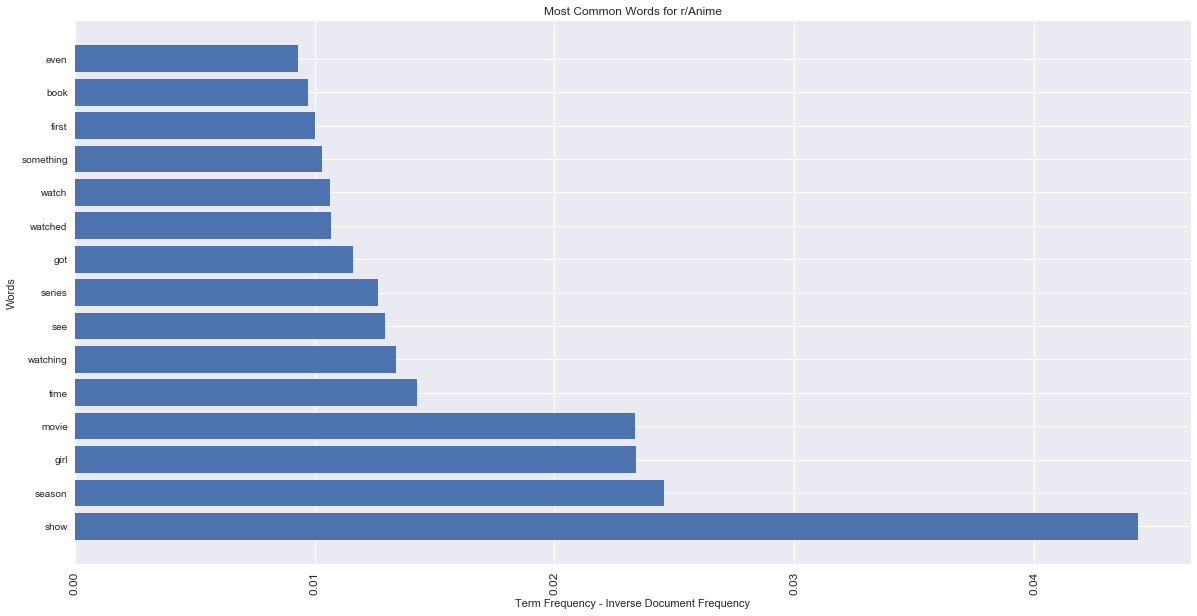

In [148]:
anilist = sorted(list(zip(rfc_anime.feature_importances_, feats_ent)),reverse = True)
lstfeats_ani = []
lst_vals_ani = []
for i in anilist:
    lst_vals_ani.append(i[0])
    lstfeats_ani.append(i[1])
    if len(lstfeats_ani) == 15:
        break
fig, ax = plt.subplots(figsize = (20,10))
plt.barh(lstfeats_ani, lst_vals_ani ) 
plt.xticks(rotation=90, fontsize = 12)
ax.set_title("Most Common Words for r/Anime")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency')


My recall for the anime model is 0.6475493533015657 and my precision is 0.9556299706990372


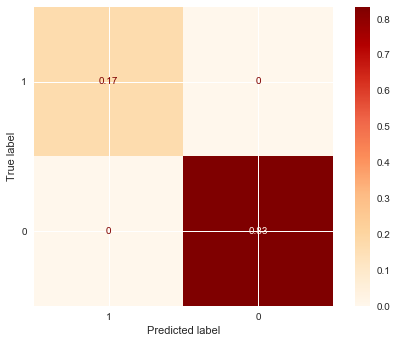

In [121]:
import itertools
pred_ani = rfc_anime_full.predict(X_test_anime)
cm = confusion_matrix(y_test_anime, pred_ani)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_anime_full, X_test_anime, pred_ani, labels = [1,0],normalize = 'all', cmap = "OrRd")
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the anime model is {recall} and my precision is {precision}')

In [828]:
sorted(list(zip(rfc_Anime.feature_importances_, feats_ent)))

[(0.0019259397482239524, 'would'),
 (0.001936017634228288, 'least'),
 (0.002470192397232392, 'watch'),
 (0.002532240486803361, 'ever'),
 (0.002547761063435647, 'series'),
 (0.0025504744281263474, 'first'),
 (0.0025610307061039116, 'without'),
 (0.0026262961771151934, 'favorite'),
 (0.002656172822848171, 'watched'),
 (0.0026658907350136356, 'show'),
 (0.0027046193951050183, 'nice'),
 (0.0027279573921246626, 'dark'),
 (0.0027356562358888544, 'movie'),
 (0.002737399811209283, 'find'),
 (0.002776696475035548, 'though'),
 (0.0027795679941952202, 'kid'),
 (0.002817705283690343, 'friend'),
 (0.0028571892663975273, 'story'),
 (0.002857867868980416, 'around'),
 (0.002896965776452426, 'big'),
 (0.0029352875519486144, 'death'),
 (0.002986692922835178, 'deadpool'),
 (0.0030444346908095987, 'fan'),
 (0.003066157556095549, 'seems'),
 (0.003191121946110235, 'real'),
 (0.003203857522168424, 'issue'),
 (0.0032107977325530157, 'next'),
 (0.003226640623959252, 'keep'),
 (0.0032403919811429495, 'go'),
 (0

In [30]:
rfc_anime_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_anime_full.fit(X_ent, y_anime)
rfc_anime_full.oob_score

True

### Movies

In [31]:
y_mov = dummiezed['Subreddit_movies']
X_train_mov, X_test_mov, y_train_mov, y_test_mov = train_test_split(X_ent, y_mov, test_size=0.20)

In [32]:
rfc_movies =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_movies.fit(X_train_mov, y_train_mov)
print(cross_val_score(rfc_movies, X_test_mov, y_test_mov, cv=3, scoring = 'f1'))


[0.78278537 0.77638145 0.77492771]


In [131]:
f1_movies = np.mean([0.78278537, 0.77638145, 0.77492771])
f1_movies

0.77803151

In [33]:
sorted(list(zip(rfc_movies.feature_importances_, feats_ent)))

[(0.0006270192415902626, 'track'),
 (0.0006731214670068758, 'voldemort'),
 (0.000739051332079136, 'winner'),
 (0.0010582221715085061, 'snape'),
 (0.0011211848569157542, 'nomination'),
 (0.0011651256603750911, 'dumbledore'),
 (0.0011905911734201623, 'band'),
 (0.0014150276701561956, 'voice'),
 (0.0014523147288068596, 'run'),
 (0.0015600651903448308, 'rey'),
 (0.0016631967486020042, 'huge'),
 (0.0016763777982950875, 'talk'),
 (0.0017466881555592317, 'fuck'),
 (0.0018520447737331623, 'batman'),
 (0.0019138588495220385, 'making'),
 (0.0019464029402634889, 'reading'),
 (0.0019707113345557806, 'eye'),
 (0.0020064438410151357, 'listen'),
 (0.0020588177659483812, 'together'),
 (0.0020781423271932077, 'thread'),
 (0.0020980772970996876, 'girl'),
 (0.002101703944662561, 'james'),
 (0.0021063472348166455, 'person'),
 (0.0021120440450882573, 'white'),
 (0.002124102263620038, 'family'),
 (0.0021490603185562, 'stand'),
 (0.0021668160143422308, 'house'),
 (0.002183630691974118, 'able'),
 (0.002188631

Text(0.5, 0, 'Term Frequency - Inverse Document Frequency ')

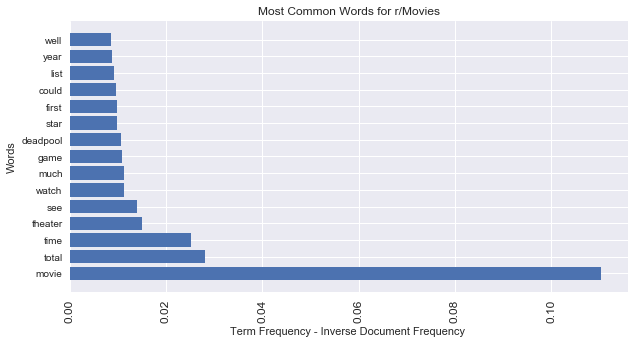

In [150]:
movlist = sorted(list(zip(rfc_movies.feature_importances_, feats_ent)),reverse = True)
lstfeats_mov = []
lst_vals_mov = []
for i in movlist:
    lst_vals_mov.append(i[0])
    lstfeats_mov.append(i[1])
    if len(lstfeats_mov) == 15:
        break
fig, ax = plt.subplots(figsize = (10,5))
plt.barh(lstfeats_mov, lst_vals_mov) 
plt.xticks(rotation=90, fontsize = 12)
ax.set_title("Most Common Words for r/Movies")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency ')


In [34]:
rfc_movies_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_movies_full.fit(X_ent, y_mov)
rfc_movies_full.oob_score

True

[0 0 0 ... 0 0 0]
My recall for the movie model is 0.6706555120194854 and my precision is 0.9336576735957541


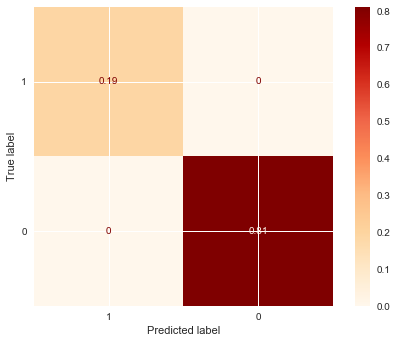

In [119]:
import itertools
pred_mov = rfc_movies_full.predict(X_test_mov)
print(pred_mov)
cm = confusion_matrix(y_test_mov, pred_mov)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_movies_full, X_test_mov, pred_mov,labels = [1,0], normalize = 'all', cmap = "OrRd")
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the movie model is {recall} and my precision is {precision}')

### Potter

In [36]:
y_potter = dummiezed['Subreddit_harrypotter']
X_train_pot, X_test_pot, y_train_pot, y_test_pot = train_test_split(X_ent, y_potter, test_size=0.20)

In [37]:
rfc_potter =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_potter.fit(X_train_pot, y_train_pot)
print(cross_val_score(rfc_potter, X_test_pot, y_test_pot, cv=3, scoring = 'f1'))


[0.78714639 0.77408638 0.77857936]


In [132]:
np.mean([0.78714639, 0.77408638, 0.77857936])


0.7799373766666666

In [38]:
sorted(list(zip(rfc_potter.feature_importances_, feats_ent)))

[(0.00010271735107304748, 'band'),
 (0.00017657198490726465, 'nomination'),
 (0.00020200463297395576, 'rey'),
 (0.00022850244725472837, 'winner'),
 (0.0002301614796585157, 'alien'),
 (0.00045774714272358164, 'artist'),
 (0.0005071782435278368, 'voice'),
 (0.0005567859210487995, 'tidal'),
 (0.0005611774724133304, 'jedi'),
 (0.0005654954658118872, 'season'),
 (0.0005770678131036378, 'ending'),
 (0.0005780027722642861, 'fight'),
 (0.0006372040964048606, 'liked'),
 (0.0006704462925828043, 'track'),
 (0.0006882930623825814, 'high'),
 (0.0007124411834393082, 'action'),
 (0.0008034920693270629, 'seeing'),
 (0.000838154392168057, 'batman'),
 (0.0008453621630228345, 'hear'),
 (0.0009035241129569342, 'spoiler'),
 (0.0009403165803616313, 'three'),
 (0.0009449940144052661, 'force'),
 (0.0009479061223558608, 'kanye'),
 (0.0010071351316453085, 'play'),
 (0.001034987431166357, 'instead'),
 (0.0010357277963026143, 'luke'),
 (0.0011245736760372264, 'thread'),
 (0.0011784241680935234, 'line'),
 (0.00120

Text(0.5, 0, 'Term Frequency - Inverse Document Frequency ')

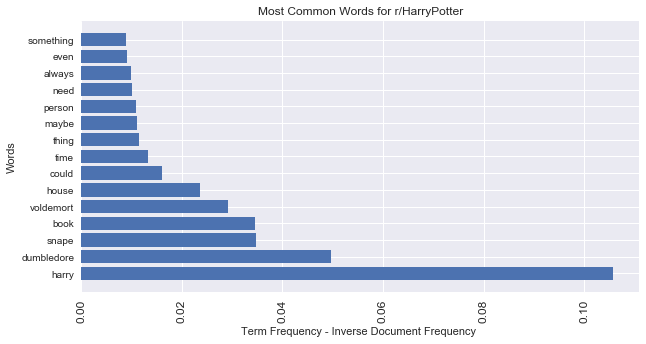

In [156]:
potlist = sorted(list(zip(rfc_potter.feature_importances_, feats_ent)), reverse = True)
lstfeats_hp = []
lst_vals_hp = []
for i in potlist:
    lst_vals_hp.append(i[0])
    lstfeats_hp.append(i[1])
    if len(lstfeats_hp) == 15:
        break
fig, ax = plt.subplots(figsize = (10,5))
plt.barh(lstfeats_hp, lst_vals_hp) 
plt.xticks(rotation=90, fontsize = 12)
ax.set_title("Most Common Words for r/HarryPotter")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency ')

In [100]:
rfc_potter_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_potter_full.fit(X_ent, y_potter)
rfc_potter_full.oob_score

True

[0 0 0 ... 0 0 0]
My recall for the potter model is 0.6439417415556244 and my precision is 0.9771925699506231


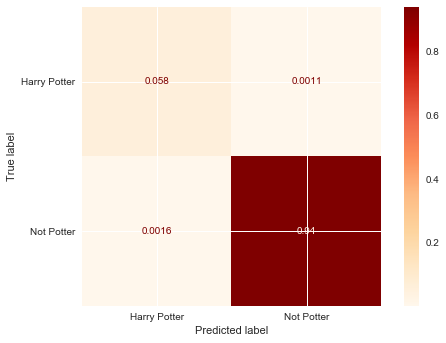

In [164]:
pred_pot = rfc_potter.predict(X_test_pot)
print(pred_pot)
cm = confusion_matrix(y_test_pot, pred_pot)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_potter_full, X_test_pot, pred_pot ,labels = [1,0], display_labels = ['Harry Potter', 'Not Potter'], normalize = 'all', cmap = "OrRd")
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the potter model is {recall} and my precision is {precision}')

### comic books

In [42]:
y_comic = dummiezed['Subreddit_comicbooks']
X_train_com, X_test_com, y_train_com, y_test_com = train_test_split(X_ent, y_comic, test_size=0.20)

In [43]:
rfc_comic =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_comic.fit(X_train_com, y_train_com)

print(cross_val_score(rfc_comic, X_test_com, y_test_com, cv=3, scoring = 'f1'))


[0.80614859 0.79572856 0.78951965]


In [133]:
np.mean([0.80614859, 0.79572856, 0.78951965])

0.7971322666666666

In [44]:
sorted(list(zip(rfc_comic.feature_importances_, feats_ent)))

[(2.7812853215617547e-05, 'nomination'),
 (6.319761969633202e-05, 'winner'),
 (0.00012173268419777285, 'voldemort'),
 (0.000286136431764443, 'rey'),
 (0.00031992100299388723, 'snape'),
 (0.0005009271954028537, 'listen'),
 (0.0005636170384657024, 'band'),
 (0.0005664395454456441, 'dumbledore'),
 (0.0005731815156665841, 'jedi'),
 (0.0006192706316270795, 'fight'),
 (0.0007472169011329609, 'school'),
 (0.0008917724104311899, 'came'),
 (0.0009406785131294815, 'house'),
 (0.0009415277570723492, 'tidal'),
 (0.0009900149725970927, 'fact'),
 (0.0010347974561907814, 'person'),
 (0.0010892407091734357, 'found'),
 (0.0011005719215829571, 'thread'),
 (0.0011219351223955047, 'voice'),
 (0.001128064388677073, 'link'),
 (0.0011459376969521272, 'talk'),
 (0.0011651789688599307, 'white'),
 (0.0011736630527598483, 'change'),
 (0.0011767516209435476, 'eye'),
 (0.0012280081527026535, 'track'),
 (0.0012478353777051969, 'luke'),
 (0.0012600733436722957, 'total'),
 (0.0012710001112629357, 'theater'),
 (0.0013

Text(0.5, 0, 'Term Frequency - Inverse Document Frequency')

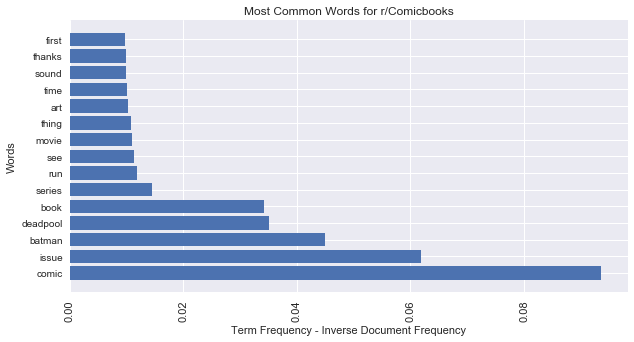

In [157]:
com_list = sorted(list(zip(rfc_comic.feature_importances_, feats_ent)), reverse = True)
lstfeats_comics = []
lst_vals_comics = []
for i in com_list:
    lst_vals_comics.append(i[0])
    lstfeats_comics.append(i[1])
    if len(lstfeats_comics) == 15:
        break

fig, ax = plt.subplots(figsize = (10,5))
plt.barh(lstfeats_comics, lst_vals_comics) 
plt.xticks(rotation=90, fontsize = 11)
ax.set_title("Most Common Words for r/Comicbooks")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency')



In [51]:
rfc_comic_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_comic_full.fit(X_ent, y_comic)
rfc_comic_full.oob_score

True

[0 0 0 ... 0 0 0]
My recall for the comic model is 0.6990823857969279 and my precision is 0.9334132374483952


array([61009,   500,  3017,  7009])

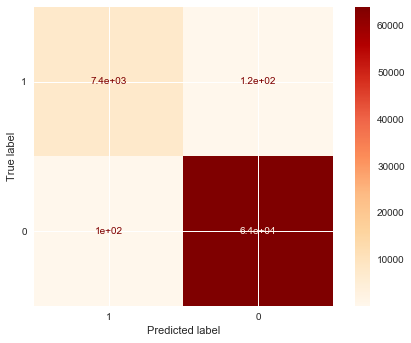

In [167]:


pred_com = rfc_comic.predict(X_test_com)
print(pred_com)
cm = confusion_matrix(y_test_com, pred_com)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_comic_full, X_test_com, pred_com, labels = [1,0], cmap = "OrRd")


tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the comic model is {recall} and my precision is {precision}')
tn, fp, fn, tp = cm.ravel()
cm.ravel()

## music

In [46]:
y_music = dummiezed['Subreddit_music']
X_train_mus, X_test_mus, y_train_mus, y_test_mus = train_test_split(X_ent, y_music, test_size=0.20)

In [47]:
rfc_music =RandomForestClassifier(n_estimators=50, max_features='log2', n_jobs = -1,  max_depth = None)
rfc_music.fit(X_train_mus, y_train_mus)
print(cross_val_score(rfc_music, X_test_mus, y_test_mus, cv=3, scoring = 'f1'))


[0.8236233  0.8118932  0.82043097]


In [134]:
np.mean([0.8236233,  0.8118932,  0.82043097])

0.8186491566666666

In [81]:
j_music = sorted(list(zip(rfc_music.feature_importances_, feats_ent)), reverse = True)
lstfeats_music = []
lst_vals_music = []
for i in j_music:
    lst_vals_music.append(i[0])
    lstfeats_music.append(i[1])
    if len(lstfeats_music) == 15:
        break

Text(0.5, 0, 'Term Frequency - Inverse Document Frequency')

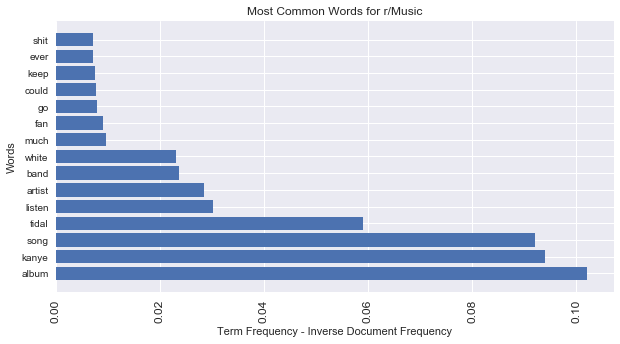

In [158]:
fig, ax = plt.subplots(figsize = (10,5))
plt.barh(lstfeats_music, lst_vals_music) 
plt.xticks(rotation=90, fontsize = 12)
ax.set_title("Most Common Words for r/Music")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency')


In [53]:
rfc_music_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_music_full.fit(X_ent, y_music)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

My recall for the music model trained on the full dataset is 0.7114647461958415 and my precision is 0.9625962596259626


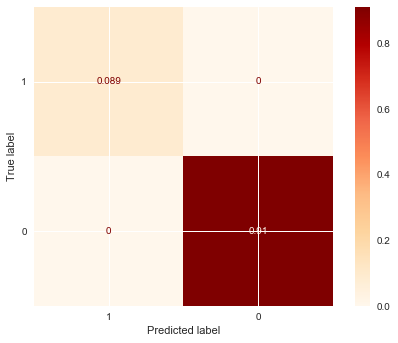

In [112]:
pred_mus = rfc_music_full.predict(X_test_mus)
# printpred_com)
cm = confusion_matrix(y_test_mus, pred_mus)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_music_full, X_test_mus, pred_mus, labels = [1,0], normalize = 'all', cmap = "OrRd")
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the music model trained on the full dataset is {recall} and my precision is {precision}')

### Star Wars

In [49]:
y_sw = dummiezed['Subreddit_starwars']
X_train_sw, X_test_sw, y_train_sw, y_test_sw = train_test_split(X_ent, y_sw, test_size=0.20)

In [50]:
rfc_sw =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None)
rfc_sw.fit(X_train_sw, y_train_sw)
print(cross_val_score(rfc_sw, X_test_sw, y_test_sw, cv=3, scoring = 'f1'))


[0.65564629 0.66600279 0.65588177]


In [135]:
np.mean([0.65564629, 0.66600279, 0.65588177])

0.65917695

In [709]:
sorted(list(zip(rfc_sw.feature_importances_, feats_ent)))

[(0.0018883867079122405, 'watch'),
 (0.002402417322113523, 'first'),
 (0.002635694615647043, 'never'),
 (0.0026583637637896773, 'maybe'),
 (0.0026868319312578497, 'already'),
 (0.002795277378705344, 'place'),
 (0.0028650956881119604, 'need'),
 (0.002960796084421828, 'top'),
 (0.0030472925757544555, 'gt'),
 (0.00308114708821017, 'long'),
 (0.003081930128704121, 'might'),
 (0.0031708025007824185, 'friend'),
 (0.0032525027793922413, 'part'),
 (0.0032636007759553596, 'movie'),
 (0.003275628445189702, 'death'),
 (0.0032845304666912793, 'nice'),
 (0.0033365632859287775, 'mean'),
 (0.003342241123668507, 'time'),
 (0.0033748749688834435, 'story'),
 (0.0035139889205014676, 'deadpool'),
 (0.003541988478582283, 'though'),
 (0.0035899031855376328, 'year'),
 (0.0036078072348049895, 'list'),
 (0.0036233504965513703, 'dark'),
 (0.0036283238887267876, 'since'),
 (0.0036929324072138394, 'keep'),
 (0.003737762552958234, 'real'),
 (0.003762152477073564, 'big'),
 (0.003785650578403294, 'issue'),
 (0.00381

Text(0.5, 0, 'Frequency of Appearance')

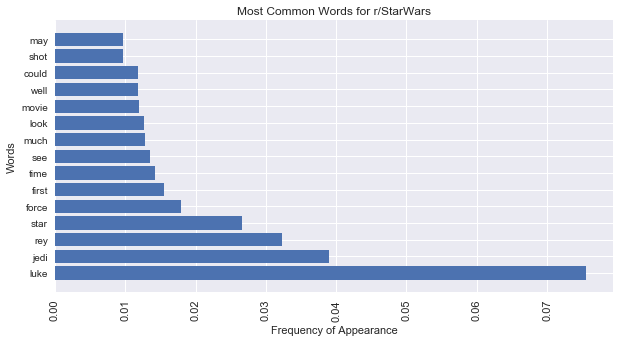

In [144]:
sw_list = sorted(list(zip(rfc_sw.feature_importances_, feats_ent)),reverse = True)
lstfeats_sw = []
lst_vals_sw = []
for i in sw_list:
    lst_vals_sw.append(i[0])
    lstfeats_sw.append(i[1])
    if len(lstfeats_sw) == 15:
        break

fig, ax = plt.subplots(figsize = (10,5))
plt.barh(lstfeats_sw, lst_vals_sw) 
plt.xticks(rotation=90, fontsize = 11)
ax.set_title("Most Common Words for r/StarWars")
ax.set_ylabel('Words')
ax.set_xlabel('Term Frequency - Inverse Document Frequency')



In [54]:
y_sw = dummiezed['Subreddit_starwars']
rfc_sw_full =RandomForestClassifier(n_estimators=50, max_features='sqrt', n_jobs = -1,  max_depth = None, oob_score=True)
rfc_sw_full.fit(X_ent, y_sw)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

My recall for the star wars model is 0.49939061547836683 and my precision is 0.9588533541341654


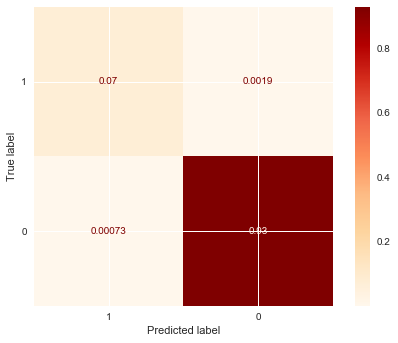

In [122]:
from sklearn.metrics import confusion_matrix
pred_sw = rfc_sw.predict(X_test_sw)
# printpred_com)
cm = confusion_matrix(y_test_sw, pred_sw)
# tn, fp, fn, tp = cm

plot_confusion_matrix(rfc_sw_full, X_test_sw, pred_sw, labels = [1,0], normalize = 'all', cmap = "OrRd")
tn, fp, fn, tp = cm.ravel()
recall = tp/(tp+fn)
precision = tp/(tp+fp)

print(f'My recall for the star wars model is {recall} and my precision is {precision}')

## Create models fit to all text data to use predict

In [887]:
Test_strings = ['Little Witch Academia is the best anime ever written. I love to watch it at night on netflix. its just like harry potter for weebs']
lsttest=piped(Test_strings)
vectors = tfidf_vectorizer.transform(lsttest)
vectors.shape
rfc_anime_full.predict_proba(vectors)

array([[0.98, 0.02]])

In [169]:
Test_string = ['Little Witch Academia is the best anime ever written. its just like harry potter for weebs']
# X_ent = tfidf_vectorizer.fit_transform(dummiezed['Tokelems']).toarray()
StarWarsstring = ['Did you ever hear the Tragedy of Darth Plagueis the wise? I thought not. Its not a story the Jedi would tell you. Its a Sith legend. Darth Plagueis was a Dark Lord of the Sith, so powerful and so wise he could use the Force to influence the midichlorians to create life... He had such a knowledge of the dark side that he could even keep the ones he cared about from dying. The dark side of the Force is a pathway to many abilities some consider to be unnatural. He became so powerful... the only thing he was afraid of was losing his power, which eventually, of course, he did. Unfortunately, he taught his apprentice everything he knew, then his apprentice killed him in his sleep. Its ironic he could save others from death, but not himself. - Sheev Palpatine']
shrek = ["I watched that scene, I Need a Hero recently. Jesus Christ, what perfection. I don't know what exactly it was, but that whole scene was like nothing I have ever seen in an movie before. It was far fetched but in a good way. The powerful voice of the Fairy Godmother, whenever she roars Hit It!, the start of one of the best scenes ever to grace movies. The transitions between Shrek and the huge gingerbread making their way to the castle and the Fairy Godmother singing was perfectly paced. A massive party inside the castle meanwhile the guards are doing their jobs to take down a huge piece of dough, Mongo screaming like a fucking dinosaur when he gets hit and starts kicking the gumdrop button back to them. The whole scene was well paced. It was fast, but balanced everything well. Amazing every single time."]

def which_ent_sub(Test_strings):
    '''
    parameters
    ------------------
    Test_strings : string of text in a list format that you want to use the predictor on
    
    returns
    -------------
    list(zip(model_names, probs)): list of tuples containing the model names and their
                                   respective false and true probabilities for being in that topic
    '''
    lsttest = piped(Test_strings)
#     print(lsttest)
    model_names = ['Anime', 'Movies', 'Comic', 'Music', 'Star Wars', 'Harry Potter']

    vectors = tfidf_vectorizer.transform(lsttest)
#     print(vectors.shape)
    models_ent = [rfc_anime_full, rfc_movies_full, rfc_comic_full, rfc_music_full, rfc_sw_full, rfc_potter_full]
    probs = []
    preds = []
    for i in models_ent:
        probs.append(i.predict_proba(vectors))
        preds.append(i.predict(vectors))
    preds_models = (list(zip(preds, model_names)))
    print(list(zip(probs, model_names)))
    for i in preds_models:
        if i[0][0]==1:
            return i
    
    return (list(zip(probs, model_names)))

res = which_ent_sub(StarWarsstring)
shrekres = which_ent_sub(shrek)
print(res)

[(array([[0.96, 0.04]]), 'Anime'), (array([[0.96, 0.04]]), 'Movies'), (array([[0.96, 0.04]]), 'Comic'), (array([[0.98, 0.02]]), 'Music'), (array([[0.15064935, 0.84935065]]), 'Star Wars'), (array([[0.94, 0.06]]), 'Harry Potter')]
[(array([[0.82, 0.18]]), 'Anime'), (array([[0.56, 0.44]]), 'Movies'), (array([[0.96, 0.04]]), 'Comic'), (array([[0.94, 0.06]]), 'Music'), (array([[0.92, 0.08]]), 'Star Wars'), (array([[1., 0.]]), 'Harry Potter')]
(array([1], dtype=uint8), 'Star Wars')


In [163]:
# below unneeded

In [ ]:
meta_model_names = ['Gaming', 'Entertainment', 'Humor', 'Learning', 'News', 'Television', 'Lifestyle']
tv_model_names = ['Community', 'Breaking Bad', 'Doctor Who','Game of Thrones', 'How I Met Your Mother', 'My Little Pony', 'Star Trek','The Walking Dead']
humor_model_names = ['Advice Animals', 'Circlejerk', 'Facepalm', 'Funny','ImGoingToHellForThis', 'Jokes']
gaming_model_names = ['Gaming', 'dota2', 'League of Legends', 'Minecraft', 'Pokemon', 'Skyrim','Starcraft', 'Team Fortress 2']
learning_model_names = ['AskScience', 'AskHistorians', 'Explain Like im 5','Science', 'Space', 'Today I Learned', 'You Should Know']
news_model_names = ['Conservative','Conspiracy', 'Libertarian', 'News', 'Offbeat', 'politics', 'truereddit', 'World News']
entertainment_model_names = ['Anime', 'Movies', 'Comic Books', 'Harry Potter', 'Music', 'Star Wars']
lifestyle_model_names = ['Drunk', 'Food', 'Frugal','Guns', 'Lifehacks', 'Motorcycle', 'ProgressPics', 'Sex']


meta_models = [rfc_meta_gaming, rfc_meta_entertainment,rfc_meta_humor, rfc_meta_learn, rfc_meta_news, rfc_meta_tv, rfc_meta_life]
tv_models = [rfc_community, rfc_breaking_bad, rfc_docwho,rfc_got,  rfc_himym, rfc_mlp, rfc_trek, rfc_twd]
humor_models = [rfc_advani, rfc_jerk, rfc_facepalm, rfc_funny, rfc_hell, rfc_jokes]
gaming_models = [rfc_gaming, rfc_dota, rfc_lol, rfc_mine, rfc_poke, rfc_skyrim, rfc_starcraft, rfc_tf2]
learning_models = [rfc_askscience, rfc_askhist, rfc_eli5, rfc_science, rfc_space, rfc_til, rfc_ysk]
news_models = [rfc_con, rfc_conspire, rfc_liber, rfc_news_sub, rfc_offbeat, rfc_poli, rfc_truereddit, rfc_worldnews]
entertainment_models = [rfc_Anime, rfc_movies, rfc_comic, rfc_potter, rfc_music, rfc_sw]
lifestyle_models = [rfc_drunk, rfc_food, rfc_frugal, rfc_guns, rfc_lifehacks, rfc_moto, rfc_progress, rfc_sex]

# Extra work and EDA

In [944]:
def piped2(arr):
    arr = clean_urls(arr)
    arr = base_clean_up(arr)
    tokens = tokenizer(arr)
    lems = lemmatization(tokens)
    lst_final = []
    for i in lems:
        i = " ".join(i)
        lst_final.append(i)
    return lems
dummiezed['tokens'] = piped2(dummiezed['Text'].values)

In [945]:
from collections import Counter
results = Counter()
dummiezed['tokens'].apply(results.update)
# print(results)
print(len(results))

# set(['someone', 'ft.jgt', 'my', 'is', 'to', 'going', 'place', 'nickname'])

17973


In [946]:
results

Counter({'see': 26930,
         'whoop': 298,
         'intergalactic': 50,
         'alien': 4444,
         'butt': 298,
         'rogue': 449,
         'anyone': 6703,
         'anything': 7549,
         '': 2721096,
         'cinematographer': 199,
         'ever': 10626,
         'finally': 3442,
         'changed': 1691,
         'thanks': 5076,
         'tom': 1095,
         'cruise': 100,
         'john': 2595,
         'anderton': 150,
         'kidnaps': 100,
         'precog': 150,
         'agatha': 100,
         'pool': 498,
         'mirroring': 50,
         'kidnapping': 150,
         'irony': 198,
         'joined': 348,
         'precrime': 50,
         'incidence': 50,
         'yet': 6175,
         'resort': 149,
         'afterwards': 448,
         'order': 5534,
         'prove': 149,
         'system': 1198,
         'worked': 1640,
         'hard': 4848,
         'develop': 348,
         'wrong': 3143,
         'movie': 30184,
         'dear': 597,
         'god':

In [953]:
resies = results.most_common(20)
resies = dict(resies)
resies_mod = dict()
for k, v in resies.items():
    if v<200000:
        resies_mod[k] = v

In [434]:
(Counter(df['meta'].values))

Counter({'news': 408716,
         'lifestyle': 384494,
         'learning': 271179,
         'humor': 382197,
         'entertainment': 379414,
         'television': 321794,
         'gaming': 578206})

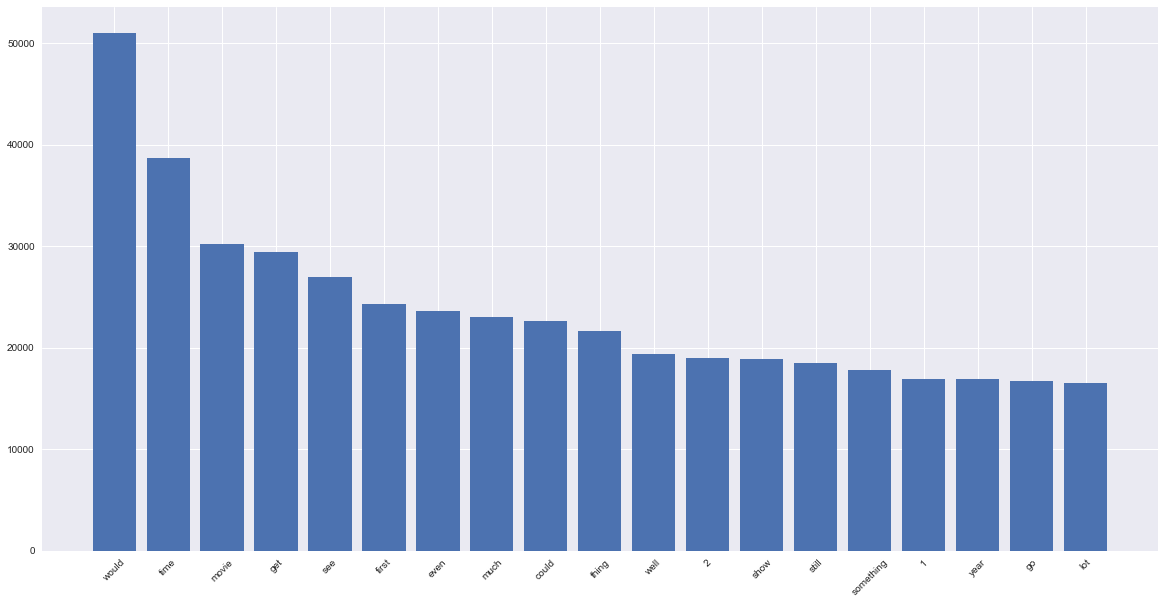

In [958]:
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(resies_mod.keys(), resies_mod.values())
plt.xticks(rotation=45)
plt.show()



# Early EDA and Exploratory Graphs
none of this was deemed valuable enough to use as a part of the models


In [145]:
dummiezed.columns

Index(['Text', 'ID', 'meta', 'Time', 'Username', 'Upvotes', 'Downvotes',
       'Author_link_karma', 'Author_Comment_Karma', 'Author_has_gold?',
       'Subreddit_anime', 'Subreddit_comicbooks', 'Subreddit_harrypotter',
       'Subreddit_movies', 'Subreddit_music', 'Subreddit_starwars',
       'tokelems'],
      dtype='object')

/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/JamesSkelton/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 1.0, "Histogram of users' link karma, removed outliers")

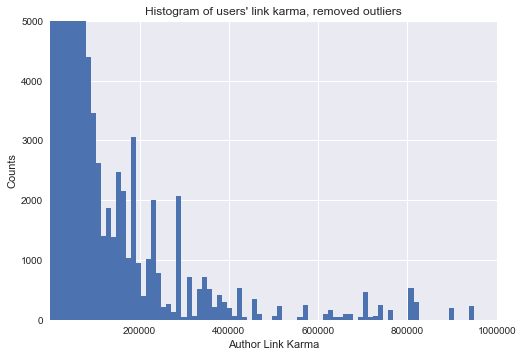

In [194]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
plt.ylim(0, 5000)
plt.xlim(5,1000000)
ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, removed outliers")

Text(0.5, 1.0, "Histogram of users' link karma, yscale log")

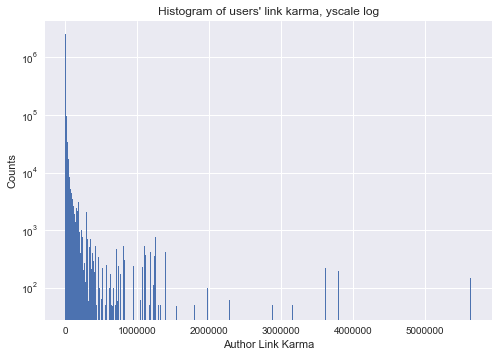

In [195]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 500)
# plt.ylim(0, 5000)
# plt.xlim(5,1000000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, yscale log")

Text(0.5, 1.0, "Histogram of users' link karma, outliers removed yscale log")

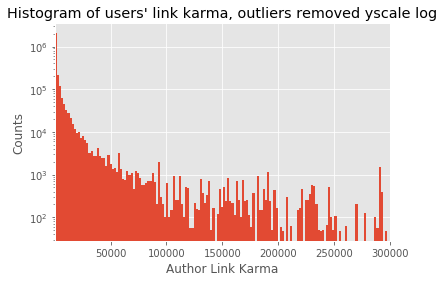

In [160]:
fig, ax = plt.subplots()
plt.hist(df.Author_link_karma, bins = 3000)
# plt.ylim()
plt.xlim(1,300000)

ax.set_yscale('log')

ax.set_xlabel('Author Link Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' link karma, outliers removed yscale log")

Text(0.5, 1.0, "Histogram of users' comment karma, removed outliers")

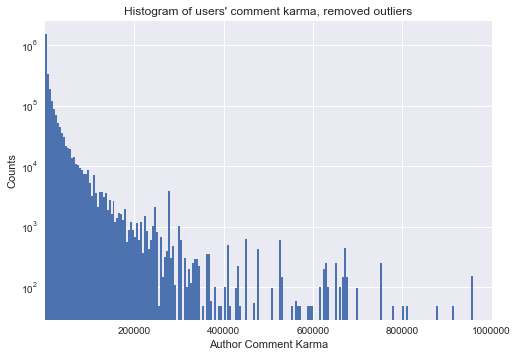

In [204]:
fig, ax = plt.subplots()
plt.hist(df.Author_Comment_Karma, bins = 500)
# plt.ylim(0, 5000)
plt.xlim(1,1000000)

ax.set_yscale('log')
ax.set_xlabel('Author Comment Karma')
ax.set_ylabel('Counts')
ax.set_title("Histogram of users' comment karma, removed outliers")

(0, 1500000)

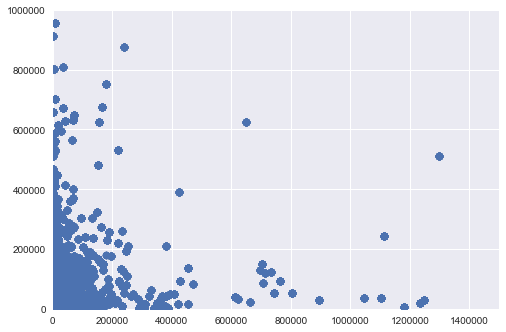

In [207]:
fig, ax = plt.subplots()

plt.scatter(df_test.Author_link_karma, df_test.Author_Comment_Karma)

# ax.set_yscale('')

ax.set_ylim(0, 1000000)
ax.set_xlim(0, 1500000)

Text(0.5, 1.0, 'Histogram of posts per hour of day')

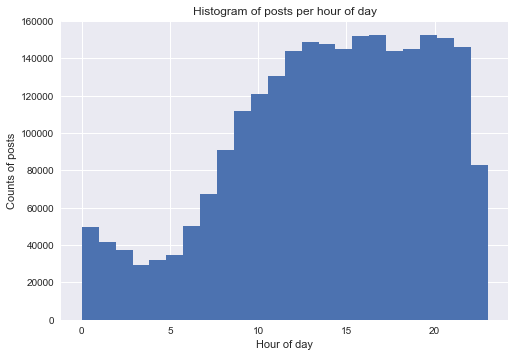

In [192]:
fig, ax = plt.subplots()

plt.hist(df.Time.dt.hour, bins = 24)
plt.style.use('seaborn')
ax.set_ylabel('Counts of posts')
ax.set_xlabel('Hour of day')
ax.set_title('Histogram of posts per hour of day')

In [126]:
import itertools

words = dummiezed['Text'].str.lower().str.findall("\w+")
words = list(itertools.chain(words))
unique = words.unique()
print(unique)

AttributeError: 'list' object has no attribute 'unique'